In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [5]:
subgraph_llm = ChatGroq(model="llama-3.1-8b-instant")

In [7]:
def translate_text(state: SubState):

    prompt = f"""
Translate the following text to Bengali.
Keep it natural and clear. Do not add extra content.

Text:
{state["input_text"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

In [8]:
subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [9]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str

In [10]:
parent_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [11]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [12]:
def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [13]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

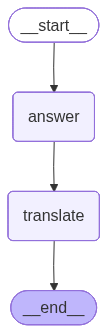

In [14]:
graph = parent_builder.compile()

graph

In [15]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics, also known as quantum mechanics, is a fundamental branch of physics that studies the behavior of matter and energy at the smallest scales – atoms, subatomic particles (like electrons, protons, and neutrons), and photons (particles of light).\n\nIt\'s called "quantum" because it describes phenomena in terms of discrete, indivisible packets, or "quanta," of energy, momentum, and other properties, rather than continuous values.\n\nHere are the key ideas that define quantum physics:\n\n1.  **Quantization:**\n    *   Unlike classical physics where quantities like energy can take any value, in the quantum world, certain properties can only exist in specific, discrete values. Imagine a staircase where you can only stand on individual steps, not anywhere in between, versus a ramp where you can stop at any point. Energy levels of electrons in an atom are quantized, for example.\n\n2.  **Wave-Particle Duality:**\n    *   On